In [ ]:
!pip install pytorch-pretrained-bert

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 123.8/123.8 kB 3.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 135.6/135.6 kB 11.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.9/10.9 MB 68.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.8/79.8 kB 10.6 MB/s eta 0:00:00


In [ ]:
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
from torch.utils.data import Dataset, DataLoader
from pytorch_pretrained_bert import BertTokenizer
from pytorch_pretrained_bert.modeling import BertModel

In [ ]:
!gdown 1yuPNBZ0zyurc7mQc4VZtg1ygfH-gq7o3
!unzip data.zip

Downloading...
From: https://drive.google.com/uc?id=1yuPNBZ0zyurc7mQc4VZtg1ygfH-gq7o3
To: /content/data.zip
100% 983k/983k [00:00<00:00, 164MB/s]
Archive:  data.zip
  inflating: gap-development.tsv     
  inflating: __MACOSX/._gap-development.tsv  
  inflating: gap-test.tsv            
  inflating: __MACOSX/._gap-test.tsv  
  inflating: gap-validation.tsv      
  inflating: __MACOSX/._gap-validation.tsv  


In [ ]:
def insert_tag(row):
    """Insert custom tags to help us find the position of A, B, and the pronoun after tokenization."""
    to_be_inserted = sorted([
        (row["A-offset"], " [A] "),
        (row["B-offset"], " [B] "),
        (row["Pronoun-offset"], " [P] ")
    ], key=lambda x: x[0], reverse=True)
    text = row["Text"]
    for offset, tag in to_be_inserted:
        text = text[:offset] + tag + text[offset:]
    return text

def tokenize(text, tokenizer):
    """Returns a list of tokens and the positions of A, B, and the pronoun."""
    entries = {}
    final_tokens = []
    for token in tokenizer.tokenize(text):
        if token in ("[A]", "[B]", "[P]"):
            entries[token] = len(final_tokens)
            continue
        final_tokens.append(token)
    return final_tokens, (entries["[A]"], entries["[B]"], entries["[P]"])

In [ ]:
class GAPDataset(Dataset):
    """Custom GAP Dataset class"""
    def __init__(self, df, tokenizer, labeled=True):
        self.labeled = labeled
        if labeled:
            tmp = df[["A-coref", "B-coref"]].copy()
            tmp["Neither"] = ~(df["A-coref"] | df["B-coref"])
            self.y = tmp.values.astype("bool")
        # Extracts the tokens and offsets(positions of A, B, and P)
        self.offsets, self.tokens = [], []
        for _, row in df.iterrows():
            text = insert_tag(row)
            tokens, offsets = tokenize(text, tokenizer)
            self.offsets.append(offsets)
            self.tokens.append(tokenizer.convert_tokens_to_ids(
                ["[CLS]"] + tokens + ["[SEP]"]))

    def __len__(self):
        return len(self.tokens)

    def __getitem__(self, idx):
        if self.labeled:
            return self.tokens[idx], self.offsets[idx], self.y[idx]
        return self.tokens[idx], self.offsets[idx], None


In [ ]:
def collate_examples(batch, truncate_len=500):
    """Batch preparation.

    1. Pad the sequences
    2. Transform the target.
    """
    transposed = list(zip(*batch))
    max_len = min(
        max((len(x) for x in transposed[0])),
        truncate_len
    )
    tokens = np.zeros((len(batch), max_len), dtype=np.int64)
    for i, row in enumerate(transposed[0]):
        row = np.array(row[:truncate_len])
        tokens[i, :len(row)] = row
    token_tensor = torch.from_numpy(tokens)
    # Offsets
    offsets = torch.stack([
        torch.LongTensor(x) for x in transposed[1]
    ], dim=0) + 1 # Account for the [CLS] token
    # Labels
    if len(transposed) == 2:
        return token_tensor, offsets, None
    one_hot_labels = torch.stack([
        torch.from_numpy(x.astype("uint8")) for x in transposed[2]
    ], dim=0)
    _, labels = one_hot_labels.max(dim=1)
    return token_tensor, offsets, labels

In [ ]:
df_train = pd.read_csv("gap-development.tsv", delimiter="\t")
df_val = pd.read_csv("gap-validation.tsv", delimiter="\t")
df_test = pd.read_csv("gap-test.tsv", delimiter="\t")

In [ ]:
BERT_MODEL = 'bert-large-uncased'
CASED = False

In [ ]:
tokenizer = BertTokenizer.from_pretrained(
    BERT_MODEL,
    do_lower_case=CASED,
    never_split = ("[UNK]", "[SEP]", "[PAD]", "[CLS]", "[MASK]", "[A]", "[B]", "[P]")
)
# These are not actually used, assigned arbitrary values.
tokenizer.vocab["[A]"] = -1
tokenizer.vocab["[B]"] = -1
tokenizer.vocab["[P]"] = -1

100%|██████████| 231508/231508 [00:00<00:00, 2666070.67B/s]


In [ ]:
train_ds = GAPDataset(df_train, tokenizer)
val_ds = GAPDataset(df_val, tokenizer)
test_ds = GAPDataset(df_test, tokenizer)
train_loader = DataLoader(
    train_ds,
    collate_fn = collate_examples,
    batch_size=5,
    num_workers=2,
    pin_memory=True,
    shuffle=True,
    drop_last=True
)
val_loader = DataLoader(
    val_ds,
    collate_fn = collate_examples,
    batch_size=5,
    num_workers=2,
    pin_memory=True,
    shuffle=False
)
test_loader = DataLoader(
    test_ds,
    collate_fn = collate_examples,
    batch_size=2,
    num_workers=2,
    pin_memory=True,
    shuffle=False
)

In [ ]:
model = BertModel.from_pretrained(BERT_MODEL)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

100%|██████████| 1248501532/1248501532 [00:26<00:00, 47125781.46B/s]


cuda


In [ ]:
# Adjusted BertFineTuningModel
class BertFineTuningModel(nn.Module):
    def __init__(self, bert_model):
        super(BertFineTuningModel, self).__init__()
        self.bert = bert_model
        self.drop = nn.Dropout(p=0.5)
        self.fc = nn.Linear(1024, 3)  # 1024 is the hidden size of BERT

    def forward(self, input_ids, attention_mask):
        _, pooled_output = self.bert(input_ids, attention_mask=attention_mask)
        logits = self.fc(pooled_output)
        return logits

In [ ]:
# Create an instance of the bertfinetuning
model = BertFineTuningModel(model)
model.to(device)

# Set the optimizer and learning rate
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-5, weight_decay=0.002)

# Set the number of training epochs
num_epochs = 4

# Set loss
loss_fn = nn.CrossEntropyLoss()  # Switched to CrossEntropyLoss as we don't apply softmax in the model

In [ ]:
# Training loop
losses=[]
val_losses=[]
for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    for tokens, offsets, labels in train_loader:
        # Move tensors to the configured device
        tokens = tokens.to(device).long()
        attention_mask = (tokens != 0).to(device).long()
        labels = labels.to(device)

        # Forward pass
        optimizer.zero_grad()
        outputs = model(tokens, attention_mask)
        loss = loss_fn(outputs, labels)

        # Backward pass
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    avg_train_loss = total_loss / len(train_loader)
    losses.append(avg_train_loss)

    # Validation loop
    model.eval()
    total_val_loss = 0
    with torch.no_grad():
        for tokens, offsets, labels in val_loader:
            tokens = tokens.to(device).long()
            attention_mask = (tokens != 0).to(device).long()
            labels = labels.to(device)

            outputs = model(tokens, attention_mask)
            loss = loss_fn(outputs, labels)

            total_val_loss += loss.item()

        avg_val_loss = total_val_loss / len(val_loader)
        val_losses.append(avg_val_loss)

    # Print the average training and validation loss for the epoch
    print(f'Epoch {epoch + 1}: train_loss = {avg_train_loss}, val_loss = {avg_val_loss}')

# Save the fine-tuned model
#torch.save(model.state_dict(), 'finetuned_bert.pth')


Epoch 1: train_loss = 0.951506832242012, val_loss = 0.9917545030856955
Epoch 2: train_loss = 0.9163109713792801, val_loss = 0.9772615103886045
Epoch 3: train_loss = 0.83825828358531, val_loss = 1.0147916962360513
Epoch 4: train_loss = 0.5974088263325393, val_loss = 1.2510317440690666


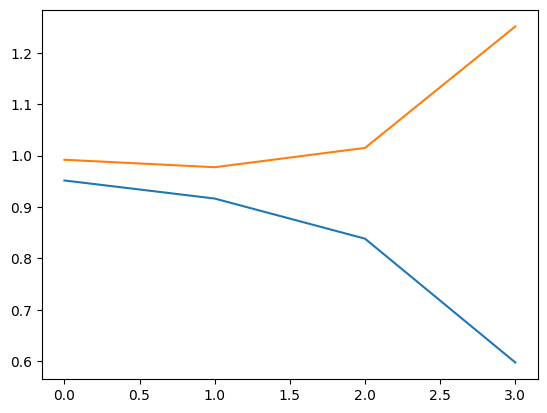

In [ ]:
import matplotlib.pyplot as plt
plt.plot(losses)
plt.plot(val_losses)

In [ ]:
#from google.colab import files
#files.download('finetuned_bert.pth')

In [ ]:
torch.save(model.state_dict(), 'finetuned_bert.pth')
from google.colab import files
files.download('finetuned_bert.pth')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## Test:

In [ ]:
model.eval()

predicted_labels = []
true_labels = []


for tokens, offsets, labels in test_loader:

    tokens = tokens.to(device).long()
    attention_mask = (tokens != 0).to(device).long()
    labels = labels.to(device)

    outputs = model(tokens, attention_mask)

    # Compute predicted labels
    _, predicted = torch.max(outputs, dim=1)

    predicted_labels.extend(predicted.tolist())
    true_labels.extend(labels.tolist())

Accuracy: 0.5435000061988831
Confusion Matrix:
[[461 434  23]
 [227 614  14]
 [100 115  12]]


Accuracy = 0.5435000061988831


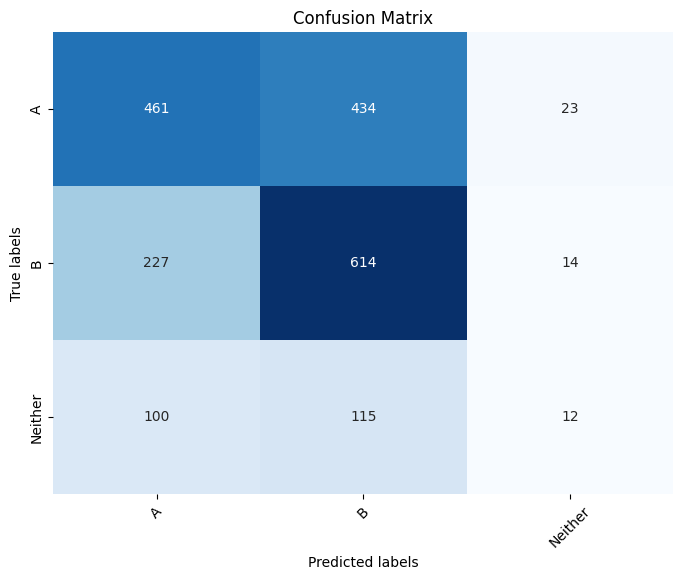

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Compute accuracy
accuracy = torch.eq(torch.tensor(predicted_labels), torch.tensor(true_labels)).float().mean().item()
print(f'Accuracy = {accuracy}')
# Compute confusion matrix
confusion_mat = confusion_matrix(true_labels, predicted_labels)

fig, ax = plt.subplots(figsize=(8, 6))
heatmap = sns.heatmap(confusion_mat, annot=True, fmt="d", cmap="Blues", cbar=False)
ax.set_xlabel("Predicted labels")
ax.set_ylabel("True labels")
ax.set_title("Confusion Matrix")
class_names = ["A", "B", "Neither"]
ax.set_xticklabels(class_names)
ax.set_yticklabels(class_names)
plt.xticks(rotation=45)

plt.show()